## False Alarm Vetting 2 for the TESS FA project
False Alarm huting 2.  This notebook is a continuation of the fas_analysis.ipynb
It reads in the mask file created from there and continues vetting.


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
qlp_file = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tcesum.csv"
spoc_file  = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/spoc_noebplanets_tcesum.csv"

col_names = ["tic","pn","sector","period","epoch","depth","dur","snr","disp","reason", "match"]
qlp_df = pd.read_csv(qlp_file, names=col_names)
spoc_df = pd.read_csv(spoc_file, names=col_names)


In [3]:
qlp_df['uniqueid'] = qlp_df['tic'].str[4:].astype(int)*100+qlp_df['sector']

In [4]:
#Created using uncrowded_kepler_targets.py
targetdf = pd.read_csv("/Users/smullally/Science/tess_false_alarms/keplerTargets/target_selection/target_tic_contamination_20210528.txt")
targetdf['uniqueid'] = targetdf['ticid']*100 + targetdf['sector']

#Merge target information into qlp TCEs.
qlp_tces = pd.merge(qlp_df, targetdf[['Tmag', 'Hmag', 'Vmag','contratio','aperture','uniqueid']], left_on="uniqueid", right_on="uniqueid", how="left" )

In [5]:
#Here is the where I read in the mask created in fas_analysis.ipynb
outmask = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tces_mask.csv"
qlpmask = np.loadtxt(outmask, dtype=str)
mask = qlpmask == 'True'
print(mask[0:10])
print(len(mask),len(qlp_tces))

[ True  True  True  True  True  True  True  True  True  True]
113040 113040


## Plot distributions
This shows everything that was found, passing or failling the vetting.
I do some grouping by uncrowded and TESS magnitude

Note, from the TIC: `contratio`: The contamination ratio is defined as the nominal flux from the contaminants divided by the flux from the source. Flux contamination is calculated for all stars in the CTL, and the procedure for TICv8 is identical to the procedure for TICv7. See section 3.3.3 of Stassun et al. (2018, AJ, 156, 102) for a complete description of the contamination ratio calculation.

Text(0.5, 0, 'SNR')

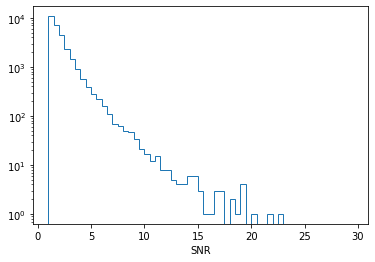

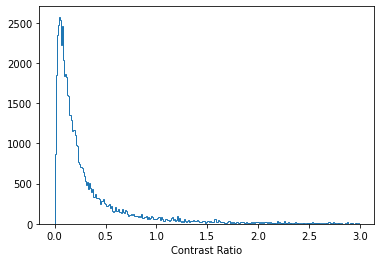

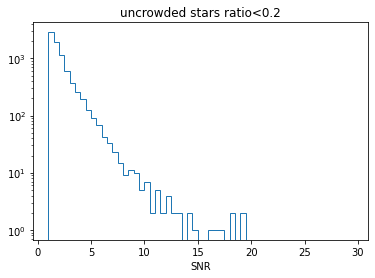

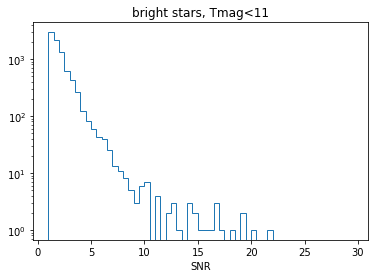

In [6]:
bins = np.arange(1,30,.5)

plt.figure()
n,bins, patches = plt.hist(qlp_tces[mask]['snr'],bins = bins,histtype='step')
plt.yscale('log')
plt.xlabel('SNR')


plt.figure()
n, bins, patches = plt.hist(qlp_tces[mask]['contratio'], histtype='step', bins=np.arange(0,3,.01))
plt.xlabel('Contrast Ratio')

uncrowded = qlp_tces['contratio'] <= 0.2

plt.figure()
n, bins, patchees = plt.hist(qlp_tces[uncrowded & mask]['snr'], histtype='step',bins=np.arange(1,30,.5))
plt.title('uncrowded stars ratio<0.2')
plt.yscale('log')
plt.xlabel('SNR')

bright = qlp_tces['Tmag'] < 11
plt.figure()
n, bins, patchees = plt.hist(qlp_tces[bright & mask]['snr'], histtype='step',bins=np.arange(1,30,.5))
plt.title('bright stars, Tmag<11')
plt.yscale('log')
plt.xlabel('SNR')

Code to do the vetting

In [7]:
import exovetter.vetters as vet
import corazon as crz
import lightkurve as lk
from exovetter.tce import Tce
from exovetter import const 

def get_lk(tcedf, author = "qlp", mission = "TESS", size = 11):
    """Returns lc and tpf given a dataframe line"""
    
    ticid = tcedf['tic'][4:]
    sector = tcedf['sector']
    
    lc = crz.gen_lightcurve.hlsp(ticid, sector, author=author)
    tpf = lk.search_tesscut(f"TIC {ticid}", sector = sector).download(cutout_size = size)
    
    return lc, tpf

def make_tce(adf, offset = 0 *u.day):
    
    atce = Tce(period = adf['period'] * u.day,
               epoch = adf['epoch'] *u.day,
               epoch_offset = offset,
               duration=adf['dur'] * u.hr, 
               depth=adf['depth'] * const.ppm,
               snr = adf['snr'])
    
    return atce

def vet_tce(tce, lc, tpf):
    """Pull up plots of the full and folded light curve.
        There are all plot from exovetter
    """
    
    results = []
    
    tc = vet.TransitPhaseCoverage()
    tpc = tc.run(tce,lc)
    results.append(tpc)
    
    try:
        mod = vet.ModShift()
        modshift = mod.run(tce, lc)
        modshift.plot()
        results.append(modshift)
    except:
        pass
    
    #sweet = vet.Sweet()
    #sweetvet = sweet.run(tce,lc)
    #sweet.plot()
    #results.append(sweet)
    #cent = vet.Centroid()
    #centout = cent.run(tce, tpf, plot=True)
    #results.append(centout)
    
    #oe = vet.OddEven()
    #oddeven = oe.run(tce,lc)
    #oe.plot()
    #results.append(oddeven)
    
    fold = vet.VizTransits(smooth=8, max_transits=5, transit_only=True)
    ntransits = fold.run(tce, lc, plot=True)
    results.append(ntransits)
    
    
    return results

## Investigate the high snr ones.  Can we remove them?

In [8]:
qlp_high_snr = qlp_tces[mask & (qlp_tces.snr > 12) &(qlp_tces.snr<=16)].copy()
qlp_high_snr

,tic,pn,sector,period,epoch,depth,dur,snr,disp,reason,match,uniqueid,Tmag,Hmag,Vmag,contratio,aperture
1741,TIC 120420775,2,26,10.5671,2014.4253,5730.727,1.0,14.54,FAIL,-NormLPP-,NaN,12042077526,8.4692,5.651,10.941,NaN,41.571069
8398,TIC 122304873,1,14,4.5216,1683.3650,85850.673,1.0,13.78,FAIL,-NormLPP--PoorTransitCoverage-,NaN,12230487314,12.6089,11.981,13.014,0.695210,24.294219
12647,TIC 123364416,1,26,10.6045,2020.8670,7099.109,1.0,15.53,FAIL,-NormLPP--PoorTransitCoverage-,NaN,12336441626,9.9880,6.958,13.370,NaN,38.372116
19740,TIC 138639226,1,14,8.7529,1684.7135,9372.486,4.0,12.29,FAIL,-NormLPP-,NaN,13863922614,10.3558,9.605,10.795,0.094232,37.883843
19745,TIC 138639275,2,14,8.7957,1684.6489,38557.432,4.0,13.48,FAIL,-NormLPP-,NaN,13863927514,12.3775,11.059,13.196,NaN,27.634799
23125,TIC 158218303,1,26,10.6152,2020.8772,3251.648,1.0,14.22,FAIL,-NormLPP--PoorTransitCoverage-,NaN,15821830326,7.7393,5.359,9.574,NaN,45.329517
24544,TIC 158324584,1,26,10.7199,2013.6998,42724.622,1.0,15.29,FAIL,-NormLPP-,NaN,15832458426,9.9145,8.504,10.832,NaN,38.463337
35471,TIC 159728081,1,15,2.6723,1713.7954,37883.190,4.0,12.18,FAIL,-SWEETHalfPeriod-SWEETAtPeriod,NaN,15972808115,12.3589,11.061,13.119,NaN,27.864837
35992,TIC 164413081,2,26,6.9596,2016.7607,16209.573,1.0,12.18,FAIL,-NormLPP--SWEETAtPeriod-SWEETTwicePeriod-,NaN,16441308126,11.4893,10.832,11.887,0.045088,34.743699
37262,TIC 164527785,11,26,6.9274,2014.5959,6204.444,1.0,13.27,FAIL,-NormLPP-,NaN,16452778526,10.3743,9.571,10.921,0.027692,37.856392


In [9]:
#Summarize the masking here, do the vetting below.
#True for false alarms
#False if is a clear transit signal or EB that leaked in
mask[[1741, 8398, 12647, 19740, 19745, 23125, 24544, 35471, 35992, 35991]]= \
    [True, False, True, False, False, True,  True,  False, False, False]

mask[[37252, 37253,37254,37255,37256, 37257, 37258, 37259,37260,37261, 37262]] =\
     [False, False, False,False,False, False,False,False,False, False, False]

mask[37262:37879] = np.ones(len(mask[37262:37879])) == 0

mask[[38566, 40340, 44097, 45828, 56275, 76597, 85468, 85473, 85471, 90382, 96261, 101062, 102335, 110129, 110130]] = \
    [False, True, True,    False, True, False, False, False, False, False, True,   True, True,    False, False]

mask[39960:39977] = np.ones(len(mask[39960:39977])) == 0

mask[49178:49183] = np.ones(len(mask[49178:49183])) == 0

mask[52509:52511] = np.ones(len(mask[52509:52511])) == 0

mask[57594:57598] = np.ones(len(mask[57594:57598])) == 0

mask[61259:61264] = np.ones(len(mask[61259:61264])) == 0

mask[61294:61298] = np.ones(len(mask[61294:61298])) == 0

mask[84282:84287] = np.ones(len(mask[84282:84287])) == 0

mask[109566:109573]= np.ones(len(mask[109566:109573])) == 0

mask[112045:112048] = np.ones(len(mask[112045:112048])) == 0

outmask = "/Users/smullally/Science/tess_false_alarms/vet_results/joe_mar_2021/first-dataset/qlp_noebplanets_tces_mask2.csv"
np.savetxt(outmask, mask, fmt="%r")

#Reasons
# 1741 has a poor detrending of a long term signal, but is not a transit
# 8398 has transits, though that isn't what it is finding
# 12647 triggering on the edge of the ligth curve
# 19740 is an EB and is a centroid offset.
# 19745 is an EB and Centroid Offset
# 23125  trigger on the. edge of the ligth curve no transit
# 24544 Trigger onthe edge
# 35471 Clear Transit/EB centroid offset is clear. TIC 159728081
# 35992 and 35991 have a CO signal so remove the first two planet numbers found.
# 37252 hasloads of CO transits
# 37262etc is a CO transit/EB which produced 16 planet candidates of high snr
# 38566 clear transit, CO
# 40340 nothing. there
# 45828 Centroid Offset
# 52509 centroid offset
# 76597 EB
# 109566  TIC 48507024 Centroid Offset
# 112045:47 EB

#Interesting
#tic          TIC 26542657  #57594. Definitely EB like, but no offset obvious .
#tic                       TIC 272272007 crowded filed, but nooffset
#TIC 27395746. dim centroid offset, but a clear example, wonder if this eb is known 
# TIC 27845677  EB is it known?
# TIC 299096355  single transit in sector 14, is it known?
# TIC 48507024 Centroid Offset
# Single Transit TIC 63007464
# TIC 63291682 EB with ellipsoidal variation, no a clear centroid offset

112047
tic                                               TIC 63291682
pn                                                           3
sector                                                      15
period                                                  8.0855
epoch                                                1717.5725
depth                                                 65474.29
dur                                                        1.0
snr                                                      13.91
disp                                                      FAIL
reason        -NormLPP--PoorTransitCoverage--SWEETHalfPerio...
match                                                      NaN
uniqueid                                            6329168215
Tmag                                                   12.7801
Hmag                                                     12.02
Vmag                                                     13.23
contratio                                       

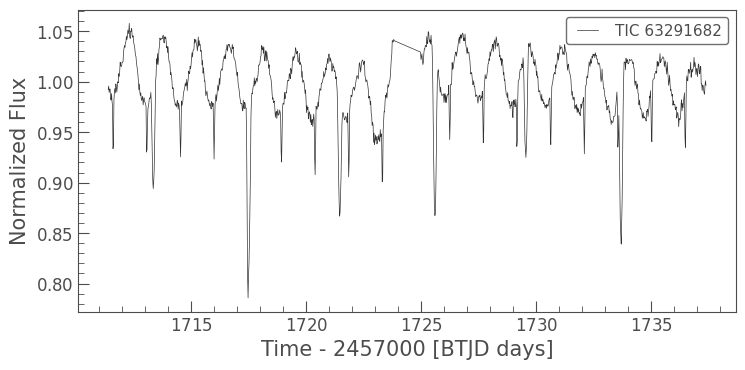

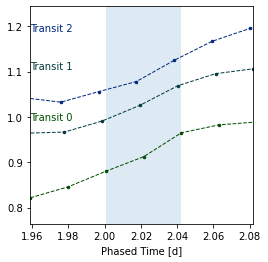

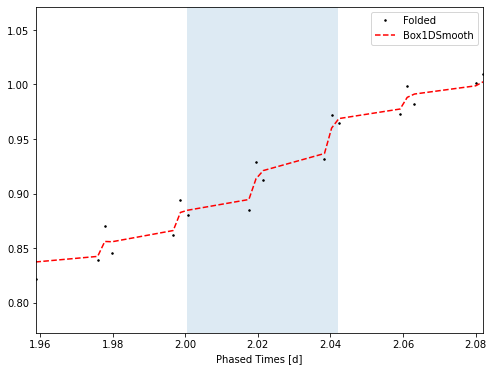

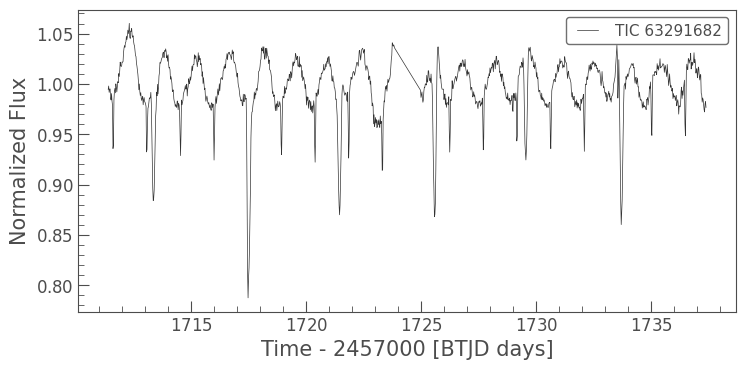

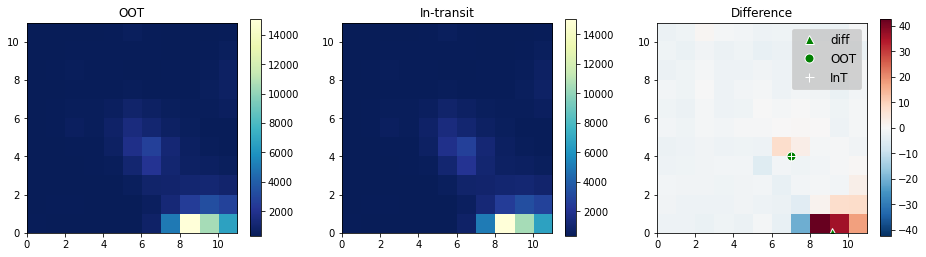

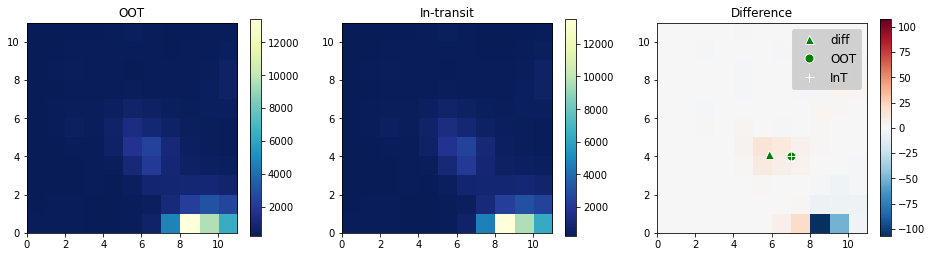

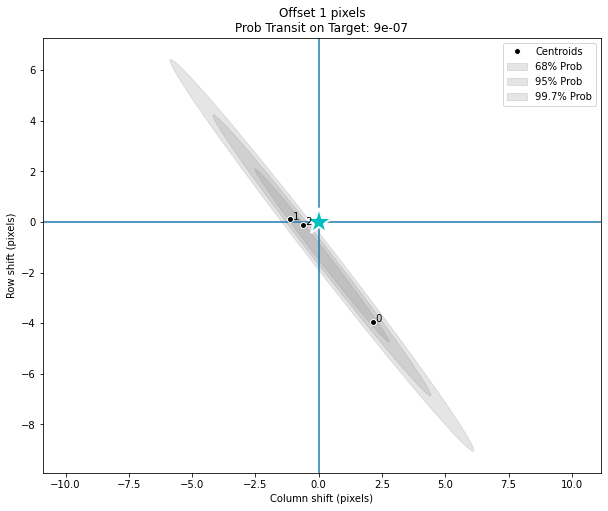

In [10]:
#Vetting code.
i = qlp_high_snr.index[36] 
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)


##Let's see the results now. and take some cumulative distributions 

Text(0.5, 0, 'SNR')

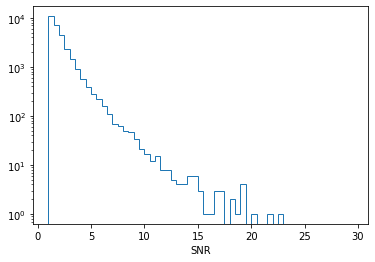

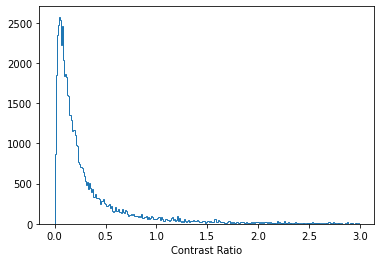

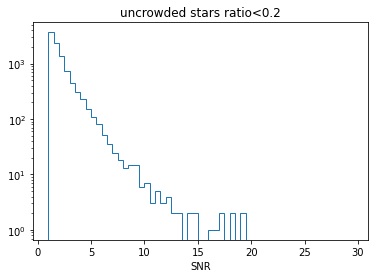

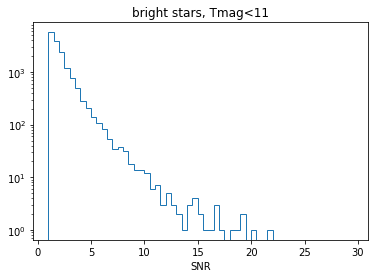

In [11]:
bins = np.arange(1,30,.5)

plt.figure()
n,bins, patches = plt.hist(qlp_tces[mask]['snr'],bins = bins,histtype='step')
plt.yscale('log')
plt.xlabel('SNR')


plt.figure()
n, bins, patches = plt.hist(qlp_tces[mask]['contratio'], histtype='step', bins=np.arange(0,3,.01))
plt.xlabel('Contrast Ratio')

uncrowded = qlp_tces['contratio'] <= 0.3

plt.figure()
n, bins, patchees = plt.hist(qlp_tces[uncrowded & mask]['snr'], histtype='step',bins=np.arange(1,30,.5))
plt.title('uncrowded stars ratio<0.2')
plt.yscale('log')
plt.xlabel('SNR')

bright = qlp_tces['Tmag'] < 12
plt.figure()
n, bins, patchees = plt.hist(qlp_tces[bright & mask]['snr'], histtype='step',bins=np.arange(1,30,.5))
plt.title('bright stars, Tmag<11')
plt.yscale('log')
plt.xlabel('SNR')

47947


Text(0.5, 0, 'SNR')

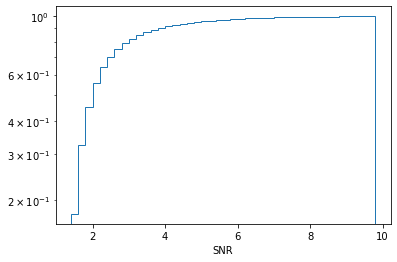

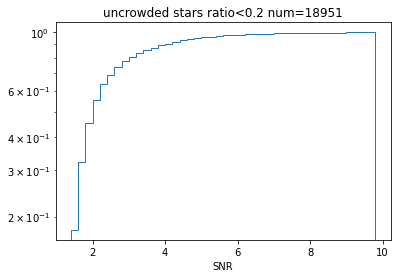

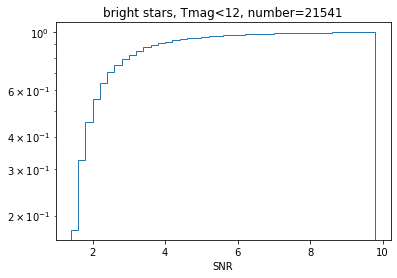

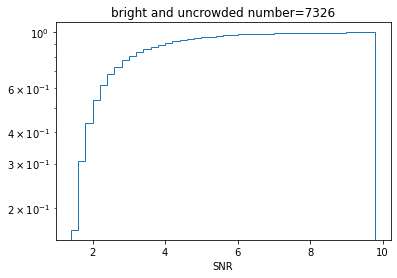

In [11]:
#Cumulative Distribution functions
print(len(np.unique(qlp_tces[mask]['tic'])))
bins = np.arange(1.4,10,.2)

plt.figure()
n,bins, patches = plt.hist(qlp_tces[mask]['snr'], bins = bins, density=True, histtype='step', cumulative=True, label = "notransit qlp")
plt.yscale('log')
plt.xlabel('SNR')

uncrowded = qlp_tces['contratio'] <= 0.3
num = len(np.unique(qlp_tces[uncrowded & mask]['tic']))
plt.figure()
n, bins, patchees = plt.hist(qlp_tces[uncrowded & mask]['snr'], histtype='step',bins=bins, density=True, cumulative=True)
plt.title('uncrowded stars ratio<0.2 num=%u' % num)
plt.yscale('log')
plt.xlabel('SNR')

bright = qlp_tces['Tmag'] < 12
num = len(np.unique(qlp_tces[bright & mask]['tic']))
plt.figure()
n, bins, patches = plt.hist(qlp_tces[bright & mask]['snr'], histtype='step',bins=bins, density=True, cumulative=True)
plt.title('bright stars, Tmag<12, number=%u' % num)
plt.yscale('log')
plt.xlabel('SNR')

#first = qlp_tces['dur'] > 1
best = uncrowded & bright 
num = len(np.unique(qlp_tces[best & mask]['tic']))
plt.figure()
n, bins, patches = plt.hist(qlp_tces[best & mask]['snr'], histtype='step',bins=bins, density=True, cumulative=True)
plt.title('bright and uncrowded number=%u' % num)
plt.yscale('log')
plt.xlabel('SNR')



## What I really want to know
For uncrowded and bright targets. For every 1,000 stars-sectors that I search, how many TCEs will I get back above a certain snr threshold.
Does this number change based on brightness of the star?
This just gives a sense of the number of false alarms, we have removed all those with EBs and transits.

Step 1: Determine the number of tCES per number of stars searched above a particular sigma (snr).  And determine if it depends on Tmag

Note this works because we know that every star searched returns at least 1 TCE, it returns only 1 if below a certain snr. (So the count of the number of stars by taking a unique of the targets with a certain crowding and brightness after masking for known EBs is fair.

In [21]:
qlp_tces['targetid'] = list(map( lambda x, y : "%s-s%u" % (x, y), qlp_tces['tic'], qlp_tces['sector']))
qlp_tces['targetid']

0         TIC 120042380-s14
1         TIC 120042380-s26
2         TIC 120042437-s14
3         TIC 120042437-s26
4         TIC 120042437-s26
                ...        
113035     TIC 63455105-s15
113036     TIC 63455142-s14
113037     TIC 63455142-s15
113038     TIC 63455142-s15
113039     TIC 63455142-s15
Name: targetid, Length: 113040, dtype: object

In [27]:
#working with uncrowded and bright targets.

sigma = 1.  #cutoff signal to noise
highsnr = qlp_tces['snr'] > sigma
tces = qlp_tces[highsnr & best & mask]

#This gives number of unique stars, but what I really want is number of unique star-sectors.
ntces = len(tces)
nstars = len(np.unique(qlp_tces[best & mask]['tic']))
print("Number of unique stars: %u" % nstars)

#This gives number of unique targetids, star-sector
nsearches = len(np.unique(qlp_tces[best & mask]['targetid']))
print("Number of star-sectors: %u" % nsearches)

ratio = ntces/nstars
print("Ratio of TCES with snr > 1 to stars: %f" % ratio)
ratio = ntces/nsearches
print("Ratio of TCES with snr > 1 to searches: %f" % ratio)

sigma = 3.  #cutoff signal to noise
highsnr = qlp_tces['snr'] > sigma
tces = qlp_tces[highsnr & best & mask]

ntces = len(tces)
nstars = len(np.unique(qlp_tces[best & mask]['tic']))
ratio = ntces/nstars
print("Ratio of TCES with snr > 3 to stars: %f" % ratio)
ratio = ntces/nsearches
print("Ratio of TCES with snr > 3 to searches: %f" % ratio)
sigma = 5.  #cutoff signal to noise
highsnr = qlp_tces['snr'] > sigma
tces = qlp_tces[highsnr & best & mask]
ntces = len(tces)
ratio = ntces/nstars
print("Ratio of TCES with snr > 5 to stars: %f" % ratio)
ratio = ntces/nsearches
print("Ratio of TCES with snr > 5 to searches: %f" % ratio)

Number of unique stars: 7326
Number of star-sectors: 13043
Ratio of TCES with snr > 1 to stars: 0.596506
Ratio of TCES with snr > 1 to searches: 0.335046
Ratio of TCES with snr > 3 to stars: 0.092274
Ratio of TCES with snr > 3 to searches: 0.051829
Ratio of TCES with snr > 5 to stars: 0.022932
Ratio of TCES with snr > 5 to searches: 0.012880


In [25]:
sigma = 3.  #cutoff signal to noise
longdur = qlp_tces['dur'] > 1
best = uncrowded & bright & longdur
highsnr = qlp_tces[best & mask]['snr'] >= sigma
sort_tces = qlp_tces[best & mask].sort_values('Tmag', inplace=False)
print(sort_tces[0:10])

                 tic  pn  sector   period      epoch    depth   dur   snr  \
72416  TIC 271545295   1      14   1.7782  1684.7406   89.151   2.0  0.87   
72417  TIC 271545295   1      15   0.8773  1711.7723   21.025  14.0  0.22   
30644  TIC 158985758   1      15   0.9519  1711.7643   48.888  14.0  0.35   
30643  TIC 158985758   1      14   0.8617  1683.9639   20.518  14.0  0.20   
49317  TIC 184010547   1      15   0.8952  1711.8035  128.355  14.0  0.24   
49316  TIC 184010547   1      14   0.9232  1684.0008  103.411  14.0  0.20   
64518   TIC 26961610   1      15   0.8172  1711.9204   71.433  14.0  0.15   
64517   TIC 26961610   1      14  10.8274  1691.9949  486.728  12.0  0.99   
42521  TIC 169183164   1      14   1.2205  1683.6757  206.869   2.0  0.95   
42522  TIC 169183164   1      15   1.0591  1712.4034  134.501   2.0  0.62   

        disp              reason  match     uniqueid    Tmag   Hmag     Vmag  \
72416   FAIL   -LowSNR--NormLPP-    NaN  27154529514  4.6882  4.219  5.0

In [26]:
sigma = 3.
nbins = 10
nstars = len(np.unique(sort_tces['tic']))
binlen = int(np.floor(nstars/nbins))

tmags = np.zeros(nbins)
ratios = np.zeros(nbins)

for i in np.arange(0,nbins,1):

    tces = sort_tces[i*binlen:(i+1)*binlen]
    nstars = len(np.unique(tces['tic']))
    highsnrtces = tces[tces['snr'] >= sigma]
    ntces = len(highsnrtces)
    ratio = ntces / nstars
    mean_tmag = np.mean(tces['Tmag'])
    tmags[i]=mean_tmag
    ratios[i]= ratio


0.04869298874926643


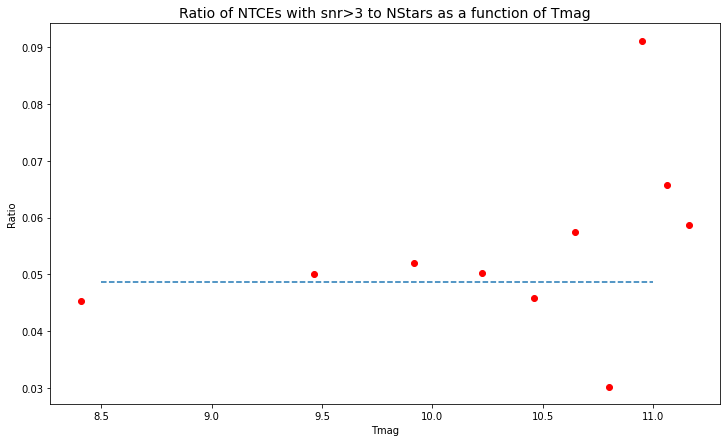

In [39]:
plt.figure(figsize = (12,7))
plt.plot(tmags,ratios,'ro')
plt.title('Ratio of NTCEs with snr>3 to NStars as a function of Tmag',fontsize=14)
plt.xlabel('Tmag')
plt.ylabel('Ratio')

meanratio = np.mean(ratios[0:5])
print(meanratio)
plt.hlines(meanratio,8.5,11,linestyle='dashed')

Note.  It seems that for bright targets there are a huge number of TCEs with a duration of 1.  I've looked at these short duration ones and they are ALWAYS terrible, at least for high signal to noise.  It looks like my planet search should not have included such a short duration.

If I don't look at the super short duration ones, then it is pretty flat at 0.0487 tces/star with almost no variation with Tmag.

## Good high snr TCEs is the real question!
This will involve vetting the final set of targets to look for the N good ones above some snr.  This may be best in a new notebook.

Here we need a new mask where we also remove anything that is not transit like until we get to ~10 good looking ones.

In [42]:
best = uncrowded & bright & longdur
sort_best = qlp_tces[best & mask].sort_values('snr', inplace=False, ascending=False)
print(len(np.unique(sort_best['tic'])))

7172


In [116]:
sort_best[800:830]

,tic,pn,sector,period,epoch,depth,dur,snr,disp,reason,match,uniqueid,Tmag,Hmag,Vmag,contratio,aperture
10759,TIC 123129687,1,26,7.2624,2016.0520,733.600,2.0,2.02,FAIL,-NormLPP-,NaN,12312968726,9.99256,9.184,10.533,0.047744,38.366445
95609,TIC 299028380,1,14,8.9614,1690.9661,3998.660,2.0,2.02,FAIL,-NormLPP-,NaN,29902838014,11.95250,11.147,11.981,0.058823,31.867303
23593,TIC 158272932,1,26,9.7537,2011.5519,480.888,8.0,2.02,FAIL,-NormLPP-,NaN,15827293226,8.48271,7.848,8.892,0.014615,41.519471
59203,TIC 267673771,2,26,10.6948,2010.6243,1088.545,8.0,2.02,FAIL,-NormLPP--OddEvenDetected-,NaN,26767377126,9.19990,9.085,9.158,0.020287,39.523451
5372,TIC 121276944,2,14,5.3493,1687.3430,425.646,2.0,2.02,FAIL,-NormLPP-,NaN,12127694414,8.09485,7.481,8.494,0.005715,43.250677
60753,TIC 26817153,1,15,9.0437,1714.0496,2061.901,2.0,2.02,FAIL,-NormLPP-,NaN,2681715315,11.86280,11.056,12.363,0.192728,32.539124
10684,TIC 123126250,1,14,10.8025,1686.4477,1653.650,2.0,2.01,PASS,,NaN,12312625014,10.91520,10.190,11.547,0.008978,36.798000
110812,TIC 63120841,1,15,9.8690,1714.5870,3576.958,4.0,2.01,FAIL,-NormLPP-,NaN,6312084115,10.95260,10.042,11.454,0.226220,36.700000
97939,TIC 350814678,1,15,9.4108,1713.2103,2652.390,2.0,2.01,FAIL,-NormLPP--OddEvenDetected-,NaN,35081467815,11.96700,11.291,12.433,0.063232,31.752607
76327,TIC 272183993,2,15,0.9584,1712.3223,1465.599,4.0,2.01,FAIL,-SWEETHalfPeriod-SWEETAtPeriod,NaN,27218399315,10.71630,9.988,11.473,0.165982,37.256874


84507
tic          TIC 273867216
pn                       1
sector                  15
period              7.9815
epoch            1714.6951
depth             1646.873
dur                    2.0
snr                   2.71
disp                  FAIL
reason           -NormLPP-
match                  NaN
uniqueid       27386721615
Tmag               10.7586
Hmag                 9.891
Vmag                 11.52
contratio          0.14634
aperture         37.167374
Name: 84507, dtype: object
[0. 1. 2.]
5
[-1. -1. -1. ...  3.  3.  3.]


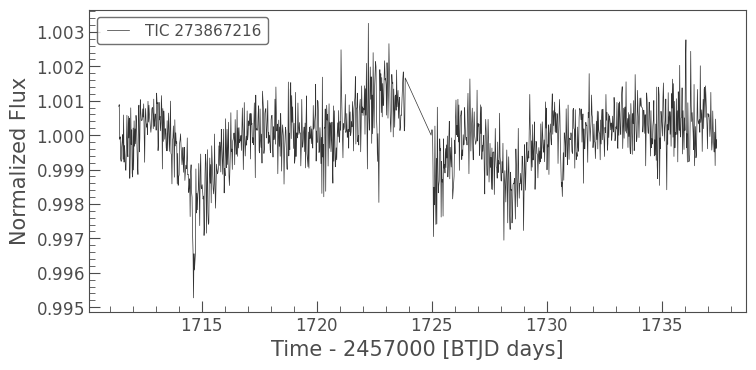

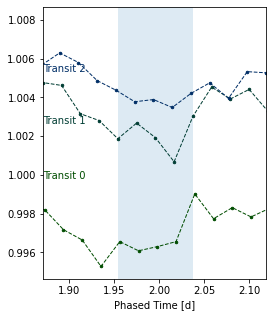

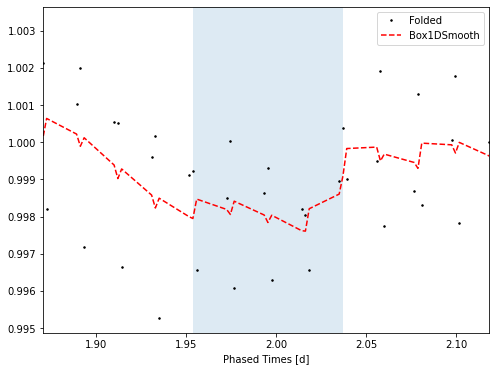

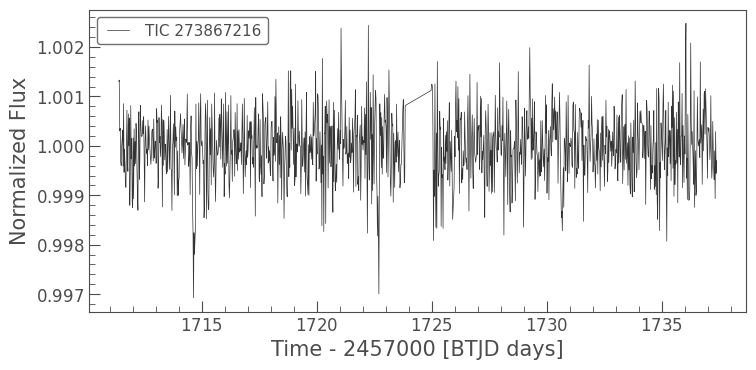

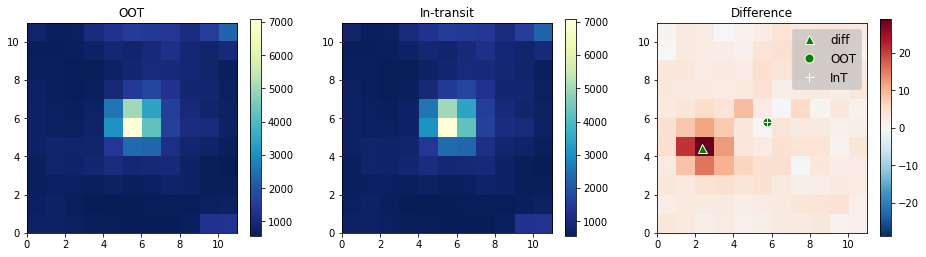

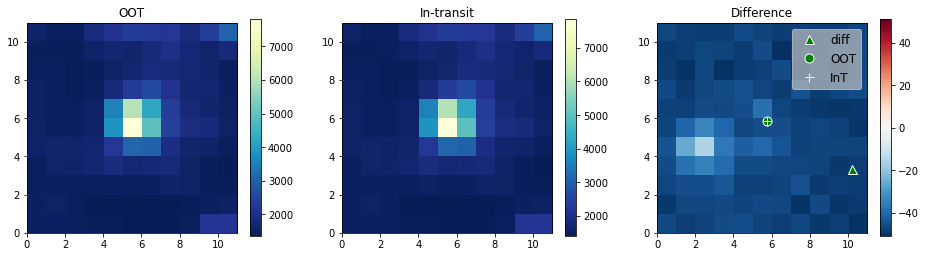

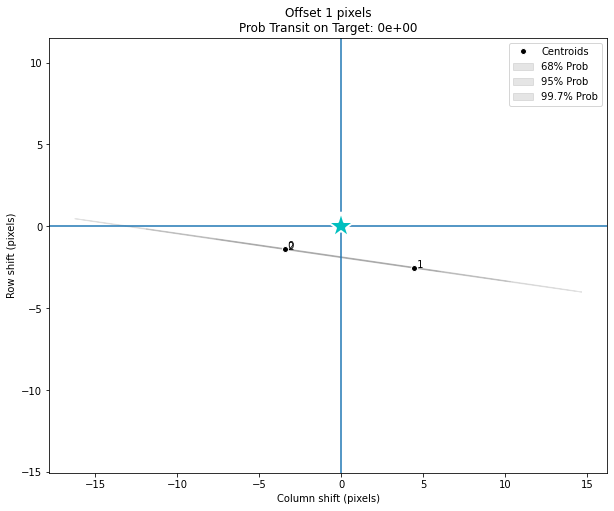

In [168]:
i = 84507 #sort_best.index[49] 
print(i)
alc, atpf = get_lk(qlp_tces.iloc[i]); 
atce = make_tce(qlp_tces.iloc[i], offset= const.btjd)
plt.show()
alc.plot()
print(qlp_tces.iloc[i])
results = vet_tce(atce, alc, atpf)
alc.flatten().plot()
cent = vet.Centroid()
centout = cent.run(atce, atpf, plot=True)


In [ ]:
good_id = []

#73519 tic          TIC 271763138 - variable star + transit
#tic            TIC 158992560 only a small centroid offset
#tic                            TIC 424867419. .6 offset centroid
#tic                     TIC 299160267 -- EB + a weird variability. is a centroid offset
#tic          TIC 272601262 - weird increase in luxes at period of 1 day with flat tops (inverted transits)
#tic                        TIC 158415241 What is this ringing, it appears systematic in nature.
#TIC 273875296 3.2 day period Centroid Offset
#tic                            TIC 275488154 centroid offset, but has a really fast rringing on top of the 1.3 day period.
#TIC 275575757 large spots, but also a clear tranist, centroid offset.
#TIC 171502723 centroid offset of a clear large flatbottom transit, single in Sector 15 - has some other weird oscillation
#What is tis artifact: 39198, weird ringing    TIC 164722725
#tic          TIC 272841744 centroid offset
#TIC 159440931 Centroid offset
#TIC 272839983 low snr, but still a clear centroid offset. snr=3.15, several transits
#TIC 158320264 EB, maybe a CO, low snr
#1.4d period centroid offset
#84507  tic          TIC 273867216  CO,low snr snr=2.2

#this takes me through a snr of 5.13. no good ones.

In [131]:
from exovetter import utils

def calc_newsnr(flux,depth):
    """
    Return a new SNR based on the actual photometric precision of the ligth curve. and the depth of the transit.
    """
    
    scatter = utils.estimate_scatter(flux)
    
    snr = depth/scatter
    return snr

    

In [169]:
atce['depth'].value

0.0016468729999999999

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

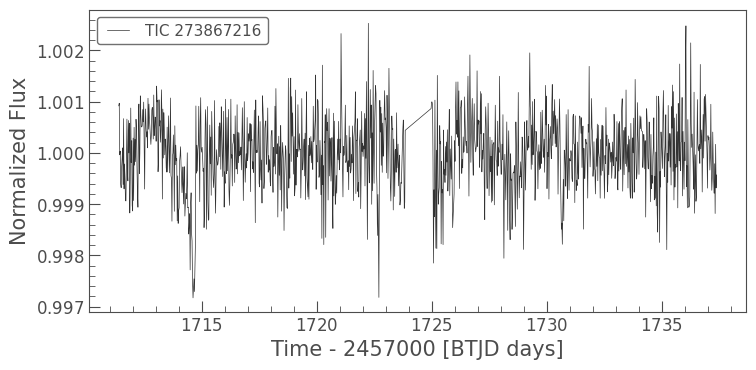

In [170]:
flat = alc.remove_outliers().flatten(window_length=201).remove_outliers()
flat.plot()
#plt.ylim(.995,1.005)

In [171]:
snr = calc_newsnr(flat.flux,atce['depth'].value)
print(snr)

2.7022992645141346


In [172]:
atce

{'period': <Quantity 7.9815 d>,
 'epoch': <Quantity 1714.6951 d>,
 'epoch_offset': <Quantity -2457000. d>,
 'duration': <Quantity 2. h>,
 'depth': <Quantity 0.00164687>,
 'snr': 2.71}

In [173]:
import astropy.units as u
durcad = int(np.ceil(atce['duration']/(0.5*u.h)))
                 
cdpp = flat.estimate_cdpp(transit_duration=durcad)
print(cdpp)
print(atce['depth'])
print(atce['depth']/(cdpp/1e6))

350.67368550765934 ppm
0.0016468729999999999
4.696311893536788 1 / ppm


In [174]:
atce['duration']/(0.5*u.h)

<Quantity 4.>

In [152]:
0.5*u.h

<Quantity 0.5 h>

In [161]:
np.ceil(atce['duration']/(0.5*u.h))

<Quantity 4.>